In [ ]:
import subprocess
import sys
import pathlib
import json
import pandas as pd
from IPython.display import Image

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
session = gj.init("opengeohub_2023/part_2")

## Development Potential
### Predictor Sampling
First we need a layer representing newly developed areas between 2001 and 2019 (value 1) and areas that didn't transition (value 0):

In [91]:
!r.mapcalc "urban_change = if(urban_2001 == 0, if(urban_2019 == 1, 1, 0), null())"

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


In [92]:
%%writefile sampling_for_county.py
import sys
import grass.script as gs

fips = sys.argv[1]

gs.run_command("g.mapsets", mapset="part_2", operation="add")
gs.run_command("g.region", raster=f"county_{fips}")
gs.run_command("r.mask", raster=f"county_{fips}")
# create an identical, virtual map of counties with different name to later simplify patching of attribute tables
gs.write_command(
    "r.reclass", input=f"county_{fips}", output="counties", rules="-", stdin="* = *"
)
gs.run_command(
    "r.sample.category",
    input="urban_change",
    output=f"sample_{fips}",
    sampled=[
        "counties",
        "devpressure_2001",
        "log_dist_to_forest_2001",
        "log_dist_to_roads_2001",
        "log_dist_to_water",
        "slope",
        "wetland_density",
    ],
    npoints=[700, 300],
    random_seed=1,
)
gs.run_command("r.mask", flags="r")

Writing sampling_for_county.py


In [93]:
%%bash
rm -f sampling_jobs.sh
for S in $(v.db.select map="counties" column="FIPS" format="csv" -c)
do
    # remove mapset to start fresh after previous run
    rm -rf opengeohub_2023/sampling_${S}
    echo grass -c opengeohub_2023/sampling_${S} --exec python sampling_for_county.py ${S} >> sampling_jobs.sh
done
parallel -j 5 < sampling_jobs.sh 2> log.txt

In [94]:
gs.run_command(
    "v.patch",
    input=[f"sample_{fips}@sampling_{fips}" for fips in county_ids],
    output="samples",
    flags="e",
)

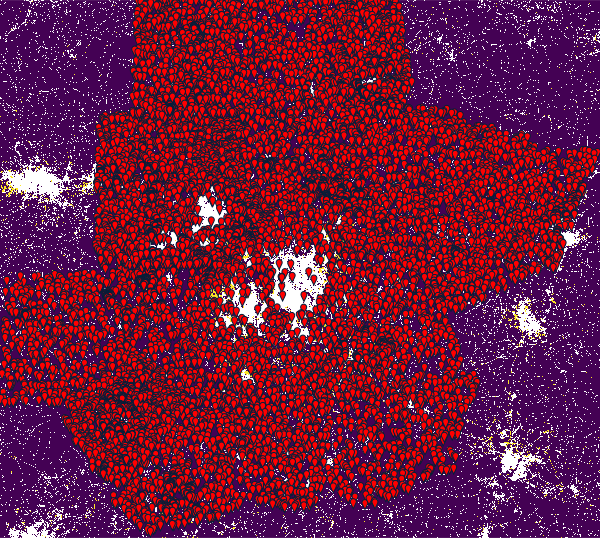

In [95]:

m = gj.Map()
m.d_rast(map="urban_change")
m.d_vect(map="samples", size=10, fill_color="red", icon="basic/pin")
m.show()

In [106]:
gs.run_command(
    "r.futures.potential",
    input="samples",
    output="best_model.csv",
    columns=[
        "devpressure_2001",
        "log_dist_to_forest_2001",
        "log_dist_to_roads_2001",
        "log_dist_to_water",
        "slope",
        "wetland_density",
    ],
    developed_column="urban_change",
    subregions_column="counties",
    random_column="devpressure_2001",
    min_variables=5,
    nprocs=2,
    flags="d",
    dredge_output="all_models.csv",
)

In [107]:
pd.read_csv("all_models.csv", index_col=0)

,Intercept,log_dist_to_forest_2001,log_dist_to_roads_2001,log_dist_to_water,slope,wetland_density,df,logLik,AIC,delta,weight
ID,,,,,,,,,,,
31,-0.573218,0.054014,-0.365222,0.281222,-0.005608,-3.394667,9,-6441.118542,12900.237084,0,1


In [108]:
pd.read_csv("best_model.csv", index_col=0)

,Intercept,devpressure_2001,log_dist_to_forest_2001,log_dist_to_roads_2001,log_dist_to_water,slope,wetland_density
ID,,,,,,,
37037,-0.820621,0.286442,0.054014,-0.365222,0.281222,-0.005608,-3.394667
37063,-0.724832,0.090407,0.054014,-0.365222,0.281222,-0.005608,-3.394667
37069,-0.928955,0.423206,0.054014,-0.365222,0.281222,-0.005608,-3.394667
37077,-0.910487,0.441704,0.054014,-0.365222,0.281222,-0.005608,-3.394667
37085,-0.845057,0.359143,0.054014,-0.365222,0.281222,-0.005608,-3.394667
37101,-0.535377,0.163393,0.054014,-0.365222,0.281222,-0.005608,-3.394667
37105,-1.027743,0.321769,0.054014,-0.365222,0.281222,-0.005608,-3.394667
37127,-0.978478,0.517394,0.054014,-0.365222,0.281222,-0.005608,-3.394667
37135,-1.358288,0.486575,0.054014,-0.365222,0.281222,-0.005608,-3.394667


In [109]:
%%bash
sed -i 's/_2001/_2019/g' best_model.csv

In [110]:
%%writefile calibration_for_county.py
import sys
import grass.script as gs

fips = sys.argv[1]

gs.run_command("g.mapsets", mapset="part_2", operation="add")
gs.run_command("g.region", raster=f"county_{fips}")
gs.run_command(
    "r.futures.calib",
    flags="sl",
    development_start="urban_2001",
    development_end="urban_2019",
    subregions=f"county_{fips}",
    patch_threshold=1800,
    patch_sizes=f"patch_sizes_{fips}.csv",
    nprocs=2,
)

Writing calibration_for_county.py


In [111]:
%%bash
rm -f calibration_jobs.sh
for S in $(v.db.select map="counties" column="FIPS" format="csv" -c)
do
    echo grass --tmp-mapset opengeohub_2023 --exec python calibration_for_county.py ${S} >> calibration_jobs.sh
done
parallel -j 5 < calibration_jobs.sh 2> log.txt